# Web Scraping Indeed.com for Key Web Developer Job Skills

## Background:

I'm currently a web designer working in West Palm Beach, Florida for a company that does a significant amount of e-commerce.

I enjoy my job and (IMHO) I'm quite good at it. I've noticed though, that every time I spend maybe several hours on creatively designing a web page enhancement and then hand over my work to one of the developers, they spend far less time coding up __my work__ ... and they all make about twice what I do!

So I've decided to enhance my skills and become a web developer. And, in case there isn't a job opening at my company, I'd like to learn the "right" skills for other nearby companies.

### The problem is - What are the "right" skills?

When I do a job search on Indeed, there are over one-hundred jobs within 25 miles of West Palm Beach. Obviously I'll need to learn HTML, CSS, and Javascript, but what about the dozens of other ones: jQuery, PHP, Angular, etc.?

## The solution:

When I told a friend of mine (who happens to be a Data Scientist) about my plans, he said he could write me a web scaper in Python (*will that be one of the skills?*) that would collect key terms from each job description on Indeed.com. All I had to provide was the web url for the initial search and it would "crawl" through the details.

The steps are the following:
* Decide what specific job(s) I'm looking for - web developer or programmer to start.
* Make a list of all the skills I'm interested in - see the second function below.
* Determine the geographical limits of my search - within 25 miles of West Palm Beach.

To run the scraper, I first need to load the following libraries and then define the two main functions: html_cleaner and web_skills_info (both below).

In [2]:
from bs4 import BeautifulSoup as soup # For HTML parsing
from urllib.request import urlopen as uReq # Website connection
import re # Regular expressions
from time import sleep # To prevent overwhelming the server between connections
from collections import Counter # Keep track of term counts
from nltk.corpus import stopwords # Filter out stopwords, such as 'the', 'or', 'and'
import pandas as pd # For converting results to a dataframe and bar chart plots
%matplotlib inline

In [3]:
def html_cleaner(website):
    '''
    This function cleans the raw html so it's parsible.
    Inputs: a URL to investigate
    Outputs: list of cleaned text
    '''
    try:
        site = uReq(website).read() # Connect to the job posting
    except: 
        return   # In case the website is not found or connection problem
    
    soup_obj = soup(site, "html.parser") # Get the html from the site
    
    if len(soup_obj) == 0: # In parser lxml didn't work, try another one
        soup_obj = soup(site, 'html5lib')
        
    for script in soup_obj(["script", "style"]):
        script.extract() # Remove these two elements from the BS4 object
        
    text = soup_obj.get_text() # Get the text
    
    lines = (line.strip() for line in text.splitlines()) # break into lines
    
    chunks = (phrase.strip() for line in lines for phrase in line.split("  ")) # break multi-headlines into a line each
    
    text = ''.join(chunk for chunk in chunks if chunk).encode('utf-8') # Remove all blank lines and ends of line
    
    # Now clean out all of the unicode
    try:
        text = text.decode('unicode_escape').encode('ascii', 'ignore') # Need this as some websites aren't formatted
    except:                                                            # in a way that this works, can occasionally throw
        return                                                         # an exception
    
    text = re.sub("[^a-zA-Z+]"," ", str(text))  # Now get rid of any terms that aren't words 
    
    text = text.lower().split()  # Go to lower case and split them apart
    
    #stop_words = set(stopwords.words("english")) # Filter out any stop words
    man_stopwords = {'ourselves', 'hers', 'between', 'yourself', 'but', 'again', 'there', 'about', 'once', 'during', 'out', 'very', 
             'having', 'with', 'they', 'own', 'an', 'be', 'some', 'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'most', 
             'itself', 'other', 'off', 'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 'themselves', 'until', 
             'below', 'are', 'we', 'these', 'your', 'his', 'through', 'don', 'nor', 'me', 'were', 'her', 'more', 'himself', 
             'this', 'down', 'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had', 'she', 'all', 'no', 
             'when', 'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 'does', 'yourselves', 
             'then', 'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 'not', 'now', 'under', 'he', 'you', 
             'herself', 'has', 'just', 'where', 'too', 'only', 'myself', 'which', 'those', 'i', 'after', 'few', 'whom', 
             't', 'being', 'if', 'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'here', 'than'}
    text = [w for w in text if not w in man_stopwords]
    
    return list(set(text))
    

In [6]:
def web_skills_info(url, city):
    '''
    This function will take a url for web development job postings
    on Indeed.com. It will crawl all of the job postings and keep track of how many
    use a preset list of typical web skills. The final percentage for each skill
    is then displayed at the end of the collation. 
    
    Input: Indeed first page url for web development search
    
    Output: A bar chart showing the most commonly desired skills in the job market for 
    a web developer. 
    '''
    current_page = url
    base_url = 'http://www.indeed.com'
    try:
        html = uReq(url).read() # Open up the front page of our search first
    except:
        'Url error - Exiting . . .'
        return
    page_obj = soup(html, "html.parser") # Get the html from the site
    
    num_jobs_area = page_obj.find(id = 'searchCount').string.encode('utf-8') # The total number of jobs found
    job_numbers = re.findall('\d+', str(num_jobs_area)) # Extract the total jobs found from the search result
    total_num_jobs = int(job_numbers[-1])
    print('There were', total_num_jobs, 'web jobs found within a 25 mi radius of ' + city + '.')
    num_pages = int(total_num_jobs/10)
    job_descriptions = [] # Store job descriptions in this list
    
    for i in range(1,num_pages+1): # Loop through search result pages (starting with the current one)
        print('Getting page ' + str(i))
        if i != 1:
            #Get next job page
            start_num = str(i*10) # Assign the multiplier of 10 to view the pages we want
            current_page = ''.join([url, '&start=', start_num]) #Set the next page of 10 jobs
            html_page = uReq(current_page).read() # Get the page
            page_obj = soup(html_page, "html.parser")
        job_link_area = page_obj.find(id = 'resultsCol') # Locate all of the links
        all_links = [link.get('href') for link in job_link_area.find_all('a')]
        all_links = [x for x in all_links if type(x) == type('')] # remove non-srings
        job_links = [x for x in all_links if 'clk' in x] # Just job related links
        
        for j in range(0,len(job_links)):
            final_description = html_cleaner(base_url + job_links[j])
            if final_description: # So that we only append when the website was accessed correctly
                job_descriptions.append(final_description)
            sleep(1) #Slow down server hits
        
    print('Done with collecting the job postings!')    
    print('There were', len(job_descriptions), 'jobs successfully found.')
    
    doc_frequency = Counter() # This will create a full counter of our terms. 
    [doc_frequency.update(item) for item in job_descriptions] # List comp
    
    #key term dicts
    prog_lang_dict = Counter({'Javascript':doc_frequency['javascript'], 'Python':doc_frequency['python'],
                    'Java':doc_frequency['java'], 'C++':doc_frequency['c++'],
                   'Ruby':doc_frequency['ruby'], 'PHP':doc_frequency['php'],
                  'CSS':doc_frequency['css'], 'HTML':doc_frequency['html'],
                  'JQuery':doc_frequency['jquery'], 'Angular': doc_frequency['angular']})
    os_dict = Counter({'Linux':doc_frequency['linux'],  'Android':doc_frequency['android'],
                      'iOS':doc_frequency['ios'], 'Windows':doc_frequency['windows'],
                      'Cloud':doc_frequency['cloud'], 'Mobile':doc_frequency['mobile'],
                      'Fullstack':doc_frequency['fullstack']})
    framework_dict = Counter({'BootStrap':doc_frequency['bootstrap'],  'Wordpress':doc_frequency['wordpress'],
                      'Node':doc_frequency['node'], 'Django':doc_frequency['django']})
    database_dict = Counter({'SQL':doc_frequency['sql'], 'NoSQL':doc_frequency['nosql'],
                 'Excel':doc_frequency['excel'], 'MySql':doc_frequency['mysql'],
                 'MongoDB':doc_frequency['mongodb']})
    overall_total_skills = prog_lang_dict + os_dict + framework_dict + database_dict # Combine our Counter objects
    
    final_frame = pd.DataFrame.from_dict(overall_total_skills, orient='index').reset_index()
    final_frame = final_frame.rename(columns={'index':'Term', 0:'NumPostings'})
    final_frame.sort_values('NumPostings', ascending = False, inplace = True)
    final_frame.NumPostings = (final_frame.NumPostings)*100/len(job_descriptions) # Gives percentage of job postings
    final_plot = final_frame.plot(x = 'Term', kind = 'bar', legend = None, 
                              title = 'Percentage of Web Developer Job Ads with a Key Skill')
    final_plot.set_ylabel('Percentage Appearing in Job Ads')
    fig = final_plot.get_figure() # Have to convert the pandas plot object to a matplotlib object
    
    return fig, final_frame

My first search will be within 25 miles of West Palm Beach.

There were 137 web jobs found within a 25 mi radius of West Palm Beach.
Getting page 1
Getting page 2
Getting page 3
Getting page 4
Getting page 5
Getting page 6
Getting page 7
Getting page 8
Getting page 9
Getting page 10
Getting page 11
Getting page 12
Getting page 13
Done with collecting the job postings!
There were 120 jobs successfully found.


(<matplotlib.figure.Figure at 0x9e8ca850b8>,           Term  NumPostings
 21         SQL    40.000000
 2         Java    39.166667
 7         HTML    30.000000
 0   Javascript    25.833333
 6          CSS    24.166667
 8       JQuery    21.666667
 14       Cloud    20.000000
 15      Mobile    17.500000
 13     Windows    15.833333
 24       MySql    15.833333
 10       Linux    10.833333
 5          PHP    10.833333
 23       Excel     9.166667
 9      Angular     7.500000
 11     Android     5.833333
 1       Python     5.833333
 18   Wordpress     5.000000
 19        Node     5.000000
 3          C++     4.166667
 12         iOS     4.166667
 17   BootStrap     3.333333
 4         Ruby     1.666667
 16   Fullstack     1.666667
 20      Django     1.666667
 22       NoSQL     1.666667)

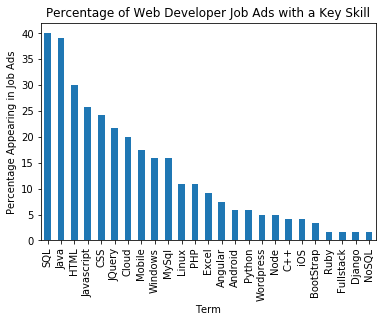

In [7]:
web_site = 'https://www.indeed.com/jobs?q=web+%28developer+or+programmer%29&l=West+Palm+Beach%2C+FL&radius=25'
web_skills_info(web_site, 'West Palm Beach')

Well, the took about 10 minutes to run, but it sure was much faster than trying to review every job description by hand.

No surprise that HTML, CSS, and Javascript are in the top ten. But I didn't expect SQL and Java to be the top two. Even though Mobile is high, both iOS and Android are low, so I'll need to focus on hybrid development rather than one or both of them. I expected Linux to be higher than Windows and I thought Python and Wordpress would be higher.

Next I'll try a search for a low-tech city about an hour north of me, Stuart.

There were 17 web jobs found within a 25 mi radius of Stuart.
Getting page 1
Done with collecting the job postings!
There were 9 jobs successfully found.


(<matplotlib.figure.Figure at 0x9e8cbedc50>,           Term  NumPostings
 14         SQL    66.666667
 4          CSS    55.555556
 5         HTML    44.444444
 3          PHP    33.333333
 6       JQuery    33.333333
 1         Java    33.333333
 0   Javascript    22.222222
 15       Excel    22.222222
 13   Wordpress    22.222222
 10       Cloud    22.222222
 11      Mobile    22.222222
 12   BootStrap    11.111111
 8        Linux    11.111111
 9      Android    11.111111
 7      Angular    11.111111
 2         Ruby    11.111111
 16       MySql    11.111111)

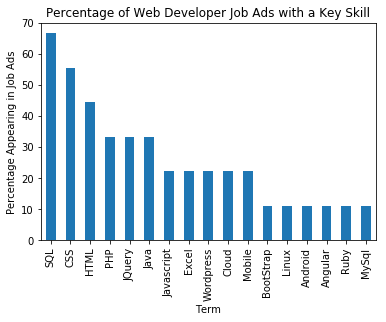

In [8]:
web_site = 'https://www.indeed.com/jobs?q=web+%28developer+or+programmer%29&l=Stuart%2C+FL&radius=25'
web_skills_info(web_site, 'Stuart')

No surprises there - that only took a couple minutes to run, but SQL was still at the top.

Next I'll try Boca Raton which is high-tech and about 1/2 hour south (perhaps I could work remotely or maybe relocate). There will be some overlap, but I'd like to see if the trends are the same.

There were 262 web jobs found within a 25 mi radius of Boca Raton.
Getting page 1
Getting page 2
Getting page 3
Getting page 4
Getting page 5
Getting page 6
Getting page 7
Getting page 8
Getting page 9
Getting page 10
Getting page 11
Getting page 12
Getting page 13
Getting page 14
Getting page 15
Getting page 16
Getting page 17
Getting page 18
Getting page 19
Getting page 20
Getting page 21
Getting page 22
Getting page 23
Getting page 24
Getting page 25
Getting page 26
Done with collecting the job postings!
There were 210 jobs successfully found.


(<matplotlib.figure.Figure at 0x9e8d4774e0>,           Term  NumPostings
 20         SQL    28.571429
 7         HTML    24.761905
 0   Javascript    24.285714
 2         Java    23.333333
 6          CSS    23.333333
 15      Mobile    18.571429
 8       JQuery    15.238095
 13     Windows    14.761905
 14       Cloud    13.333333
 9      Angular    12.857143
 5          PHP    12.857143
 23       MySql    10.476190
 10       Linux    10.000000
 18        Node     9.523810
 1       Python     8.095238
 17   Wordpress     6.666667
 16   BootStrap     5.714286
 22       Excel     5.238095
 24     MongoDB     4.761905
 21       NoSQL     4.285714
 4         Ruby     3.809524
 3          C++     3.333333
 11     Android     1.904762
 12         iOS     1.428571
 19      Django     0.476190)

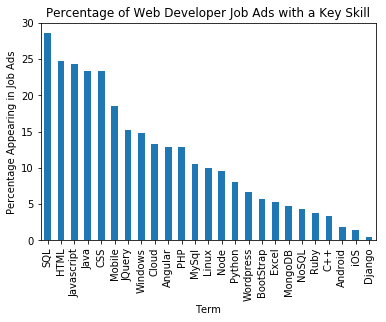

In [9]:
web_site = 'https://www.indeed.com/jobs?q=web+%28developer+or+programmer%29&l=Boca+Raton%2C+FL&radius=25'
web_skills_info(web_site, 'Boca Raton')

That took about 15 minutes to run and there were only minor differenes between West Palm Beach and Boca Raton.

## Summary:
In addition to the three core skills of HTML, CSS, and Javascript, I'll also have to focus on Java and SQL.

I'll include the next six or seven skills down to, but not including, Python.